# Photonic integrated circuit: ring resonator

## Overview
We simulate small silicon ring resonator coupled to parallel waveguides buried in silica cladding. We use midplane z PMC symmetry to slash cell count by half.

## Geometry

running luminescent python frontenda


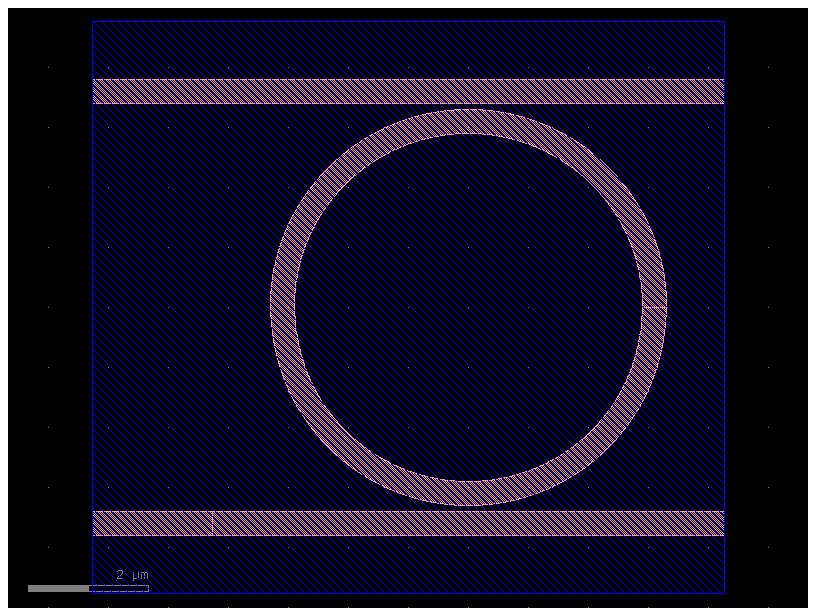

In [1]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import numpy as np
import os
import matplotlib.pyplot as plt

# simulation folder 
study='photonic_ring_resonator'
path = os.path.join('studies', study)

# length units are arbitrary so long as they are consistent, in this case [um]. everything gets normalized around origin wavelength and period at backend.
wavelength = 1.55  # characteristic wavelength [um]
bandwidth = 0.1  # wavelength bandwidth [um]
wavelengths = np.linspace(wavelength - bandwidth / 2, wavelength + bandwidth / 2, 401)

r = 3.1  # radius of ring
w_wg = 0.4  # width of waveguide
gap = 0.1  # gap between waveguide and ring
h_wg = 0.18  # h_wg of waveguide

# gds layers
WG = (1, 0)  # waveguide layer
BBOX = (10, 0)  # bounding box layer

# we create geometry in gdsfactory. alternatively, you can import .gds layout into gdsfactory or .stl bodies directly into ours

# margins
height_port_margin = lateral_port_margin = 0.8
margin = 1.2 * lateral_port_margin
zmargin = 1.2 * height_port_margin
source_port_margin = 1.0 * (w_wg + 2 * lateral_port_margin)

# draw layout in gdsfactory. `gf.components` defaults to layer WG = (1, 0)
c = gf.Component()

dut = c << gf.components.ring(radius=r, width=w_wg, layer=WG)

l_branch = 2 * r + w_wg + source_port_margin + 2*margin
xoffset = -source_port_margin - margin - r - w_wg / 2
yoffset = w_wg + gap + r
branch_top = c << gf.components.straight(length=l_branch, width=w_wg)
branch_top.move((xoffset, w_wg + gap + r))

branch_bottom_left = c << gf.components.straight(length=source_port_margin, width=w_wg)
branch_bottom_left.move((xoffset, -yoffset))

branch_bottom_right = c << gf.components.straight(length=l_branch - source_port_margin, width=w_wg)
branch_bottom_right.connect("o1", branch_bottom_left.ports["o2"])


# add ports
c.add_port("o1", port=branch_bottom_right.ports["o1"])
c.add_port("o2", port=branch_bottom_right.ports["o2"])  # thru channel
c.add_port("o3", port=branch_top.ports["o1"])  # drop channel

c << gf.components.bbox(component=c, layer=BBOX, top=margin, bottom=margin)
c.plot()

## Solve

saving mode plots to /home/weihu/lumi/luminescent/studies/photonic_ring_resonator/modes/1
showing modes for first wavelength 
mode Boundary conditions: 0A00
/home/weihu/lumi/luminescent/studies/photonic_ring_resonator/modes/1/1.5 mode 0 (neff=2.264+0.000j)
/home/weihu/lumi/luminescent/studies/photonic_ring_resonator/modes/1/1.5 mode 1 (neff=1.433+0.000j)
mode Boundary conditions: 0A00
mode Boundary conditions: 0A00
mode Boundary conditions: 0A00
mode Boundary conditions: 0A00
using simulation folder /home/weihu/lumi/luminescent/studies/photonic_ring_resonator
0.02767857142857143
Loading mesh from: /home/weihu/lumi/luminescent/studies/photonic_ring_resonator/geometry/1____Si____core____unnamed11.obj
0.02767857142857143
Loading mesh from: /home/weihu/lumi/luminescent/studies/photonic_ring_resonator/geometry/2____Si____core____unnamed21.obj
0.02767857142857143
Loading mesh from: /home/weihu/lumi/luminescent/studies/photonic_ring_resonator/geometry/4____Si____core____unnamed41.obj
0.027678

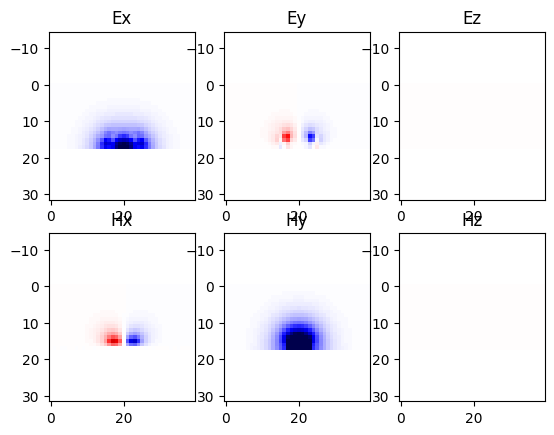

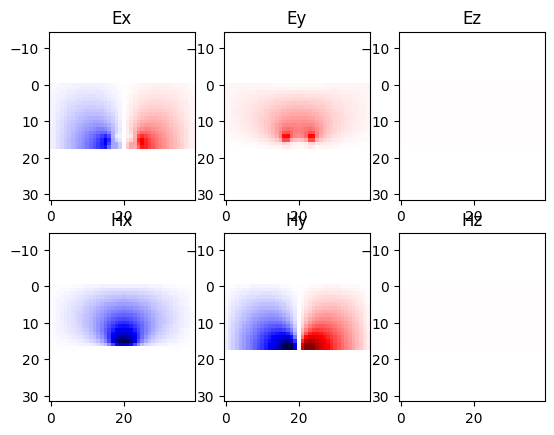

In [ ]:
# for gdsfactory, we need vertical layer stack. "core" layer is special as `height_port_margin` are demarcated from it for defining modal sources and monitors. during 3d meshing lower mesh order layers supplant higher mesh order layers
layer_stack = LayerStack(
    layers={
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=h_wg/2,
            zmin=0.0,
            material="Si",
            mesh_order=10,
        ),
    }
)

# our default lumi.MATERIAL_LIBRARY lib covers limited range of photonic and PCB material_library. here we create our own material_library. `background` is special and tags regions outside any bodies during meshing
material_library = {
    "Si": lumi.Material(epsilon=12.25),
    "SiO2": lumi.Material(epsilon=2.25),
}
material_library["background"] = material_library[
    "SiO2"
]  

# source launches `source_port_margin` in front of port. it's bidirectional: the other direction goes into PML. pulse spectrum rolls off gradually past bandwidth limits.
sources = [
    lumi.Source(
        "o1",
        source_port_margin=source_port_margin,
        wavelength=wavelength,
        bandwidth=wavelength/5,
        modenums=[0],  # fundamental mode only
    )
]

lx = w_wg + 2 * lateral_port_margin
ly = h_wg + 2 * height_port_margin
modes = [
    lumi.Mode(
        wavelengths=np.linspace(wavelengths[0], wavelengths[-1],5),
        start=[-lx / 2, 0],  # local xy frame
        stop=[lx / 2, h_wg/2 + height_port_margin],
        boundaries=['PML',('PMC','PML')]
    )
]

# Luminescent community cloud client
email=____ # replace with your registered email
client=lumi.Client(email,cloud='luminescent_community_cloud')

lumi.make(
    path=path,
    component=c,
    wavelengths=wavelengths,
    sources=sources,
    modes=modes,
    # limits
    boundaries=['PML','PML',('PMC','PML')], # z midplane PMC symmetry
    zmin=0,
    zmax=h_wg/2 + zmargin,
    # materials and layers
    material_library=material_library,
    layer_stack=layer_stack,
    # accuracy and speed settings
    nres=8,  # number of grid points per wavelength in material (not vacuum)
    relative_courant=0.95,  # relative to maximum theoretical Courant number at
    relative_pml_depths=[1, 1, 0.25],  
    tmax=1000,  # max time [periods]
    energy_decay_threshold=0.001,  # field energy decay threshold for stopping simulation
    saveat=25,  # save and plot field every _ periods, involves slow disk write
    # visualization
    views=[lumi.View("Hz",x=0,y=0,z=0)],
    # 
    client=client,
)

In [3]:
lumi.solve(path)

loading problem from /home/weihu/lumi/luminescent/studies/photonic_ring_resonator


servers:
['server0', 'READY']
['server1', 'TERMINATED']
['server2', 'ERROR']
['server3', 'ERROR']

job queue on luminescent_community_cluster:

submitted job to cluster luminescent_community_cluster
if you abort this python client, you'll also abort the job on the server!

backend loading simulation folder ...

CPU:
	threads: 48

GPU 0: NVIDIA RTX PRO 6000 Blackwell Server Edition
	CUDA Compute Capability: 12.0.0
	VRAM: 94.97076416015625 GB

setting up simulation...

meshing geometry
making sources...
making monitors...
making designs...

simulation config

backend: GPU
float: Float32

original size: (193, 158, 11)
padded size: (219, 170, 13)
cell count: 483,990

relative Courant number: 0.95
step size: 40.0 steps/period
source duration: 4.95 periods
max time: 1,004.95 periods    
energy decay threshold: 0.001

running simulation...

accumulating dft fields...
period 0.00, Inf seconds/period
period 2.50

## Visualize

Video generated successfully at /home/weihu/lumi/luminescent/studies/photonic_ring_resonator/simulation.gif!


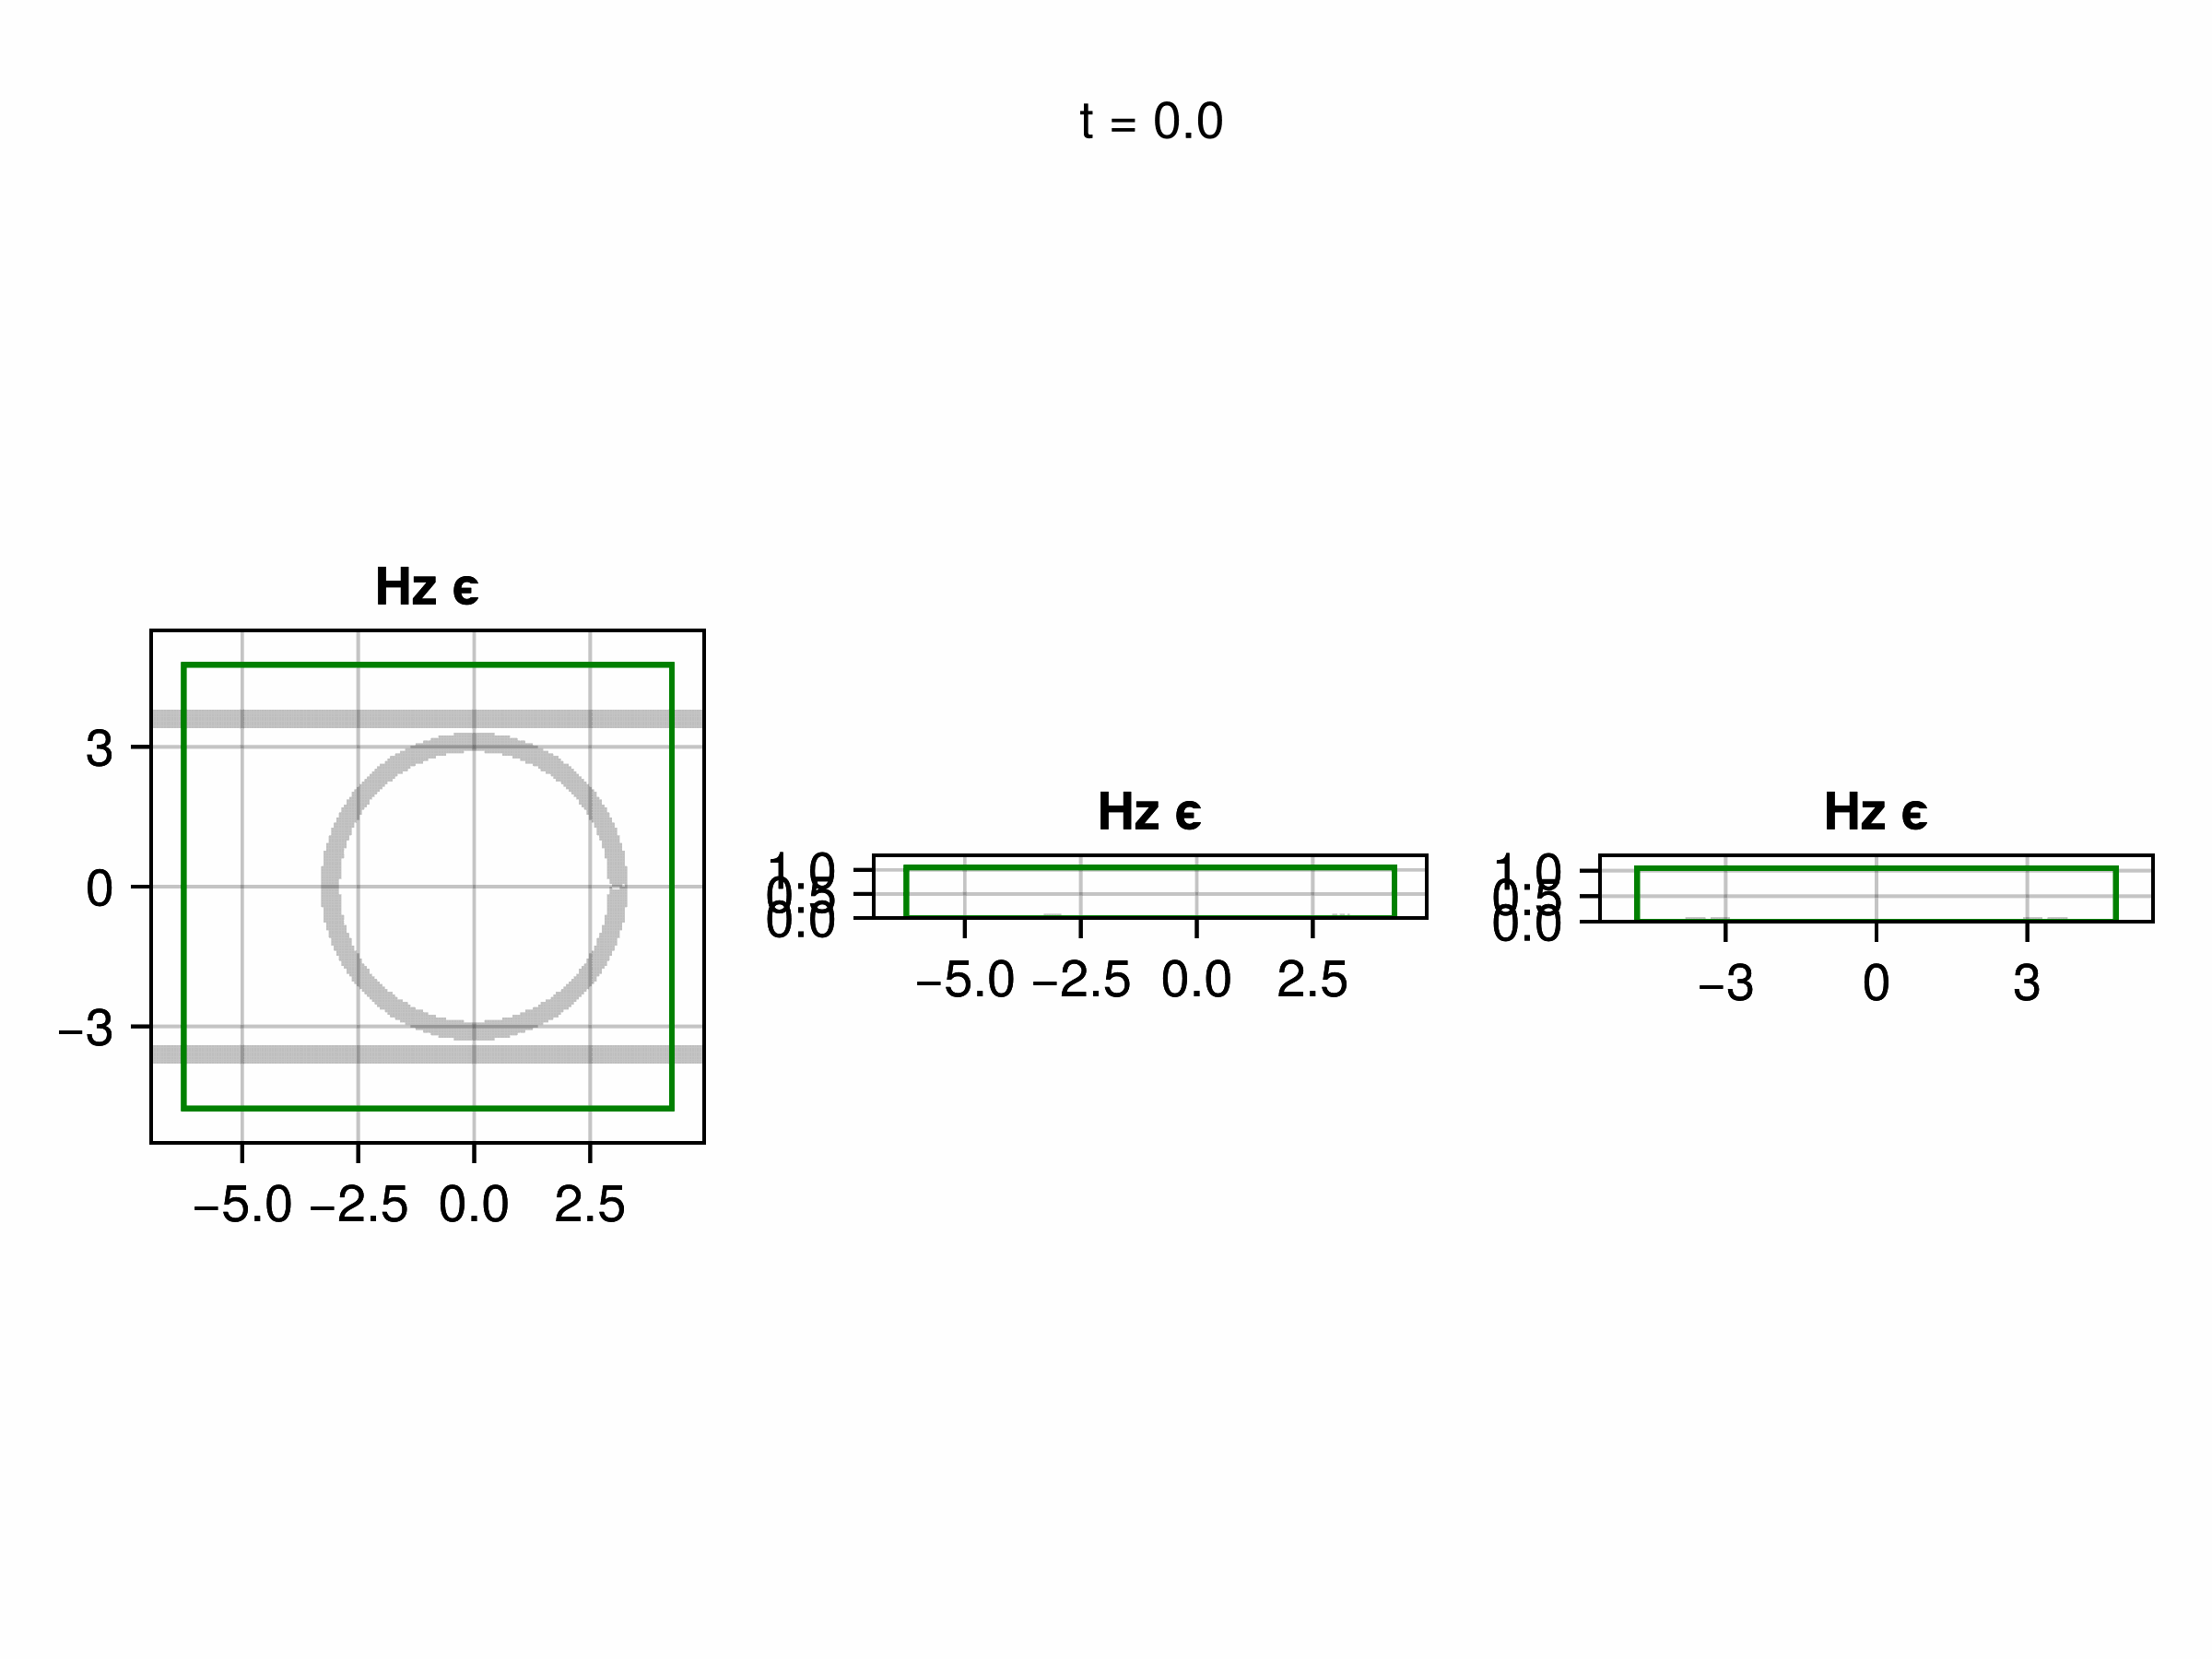

In [4]:
lumi.movie(path) # full movie - this may take a while to generate

## Analysis

loading solution from /home/weihu/lumi/luminescent/studies/photonic_ring_resonator
may take a minute if simulation folder is remotely mounted


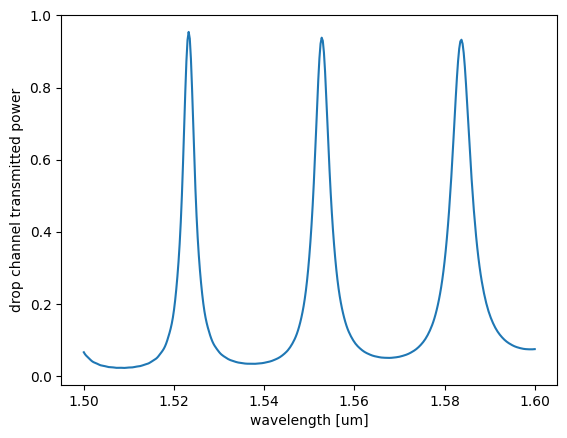

In [5]:
sol = lumi.load(path)
x = wavelengths

# S or T params. wavelength or frequency ordered depending on problem setup
y = lumi.query(sol, "To3@0,o1@0")  # same as y=np.abs2(sol['waves']['o3@0+']/sol['waves']['o1@0-'])
# y = lumi.query(sol, "T3,1") # flux

plt.plot(x, y)
plt.xlabel("wavelength [um]")
plt.ylabel("drop channel transmitted power")
plt.show()